Import dataset

In [1]:
import numpy as np
import torch
from data.dataset import OneDDatasetLoader, DatasetLoader
from typing import List
from preprocessing.batching import merge_graphs
from torch_geometric.loader import DataLoader

def train_eval_split(dataset : DatasetLoader, train_id : List, eval_id : List):
    # Get batching id
    if dataset._sub_dir == '/batched/':
        batching_id = dataset.batching_id.numpy()
        train_id = list(np.where(np.isin(batching_id, train_id) == True)[0])
        eval_id = list(np.where(np.isin(batching_id, eval_id) == True)[0])
    # Train dataset
    train_dataset = [dataset[i] for i in train_id]
    # Test dataset
    eval_dataset = [dataset[i] for i in eval_id]
    return train_dataset, eval_dataset

In [2]:
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_v2',
    sub_dir='/batched/'
)
print('Dataset loaded.')

train_dataset, test_dataset = train_eval_split(dataset,
    train_id=list(range(0,15)), eval_id=list(range(15,30)))

Dataset loaded.


In [3]:
train_loader = DataLoader(train_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

Train

In [4]:
import os
import torch
from networks.network_parc_v2 import PARC, MeshGraphNet
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from networks.network_recurrent import objectview
from networks.loss import WeightedMSELoss
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'n_fields' : 2,
    'n_timesteps' : 1,
    'n_hiddenfields' : 128,
    'n_meshfields' : dataset[0].node_attr.size(1),
    'n_bcfields' : 0,
    'timesteps' : 0.02,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr' : 5e-7,
    'weight_decay' : 1e-3,
    'epoch' : 100,
    'train_lambda' : 1.0
})

# Model initializing
model = PARC(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields,
    n_bcfields=args.n_bcfields
)

model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# criterion = torch.nn.MSELoss()
criterion = WeightedMSELoss()

In [5]:
# Train function v2
def train(model, data, args):
    n_time = data.pressure.size(1)
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    weight = data.node_weight.to(args.device)

    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate

    model.n_timesteps = n_time - 1

    Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc)

    Fs_hat = torch.cat([
        data.pressure.unsqueeze(-1), 
        data.flowrate.unsqueeze(-1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    
    F_dots_hat = torch.cat([
        data.pressure_dot.unsqueeze(-1), 
        data.flowrate_dot.unsqueeze(-1)
    ], dim=-1).to(args.device) # concat pressure and flowrate

    Fs_hat = Fs_hat[:,1:,:]
    F_dots_hat = F_dots_hat[:,1:,:]
    
    loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs, weight) + \
            args.train_lambda*criterion(F_dots_hat, F_dots, weight)

    loss.backward()
    optimizer.step()
    return loss.item()

# Eval function
def eval(model, data, args):
    n_time = data.pressure.size(1)
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    weight = data.node_weight.to(args.device)
    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc)

        Fs_hat = torch.cat([
            data.pressure.unsqueeze(-1), 
            data.flowrate.unsqueeze(-1)
        ], dim=-1).to(args.device) # concat pressure and flowrate
        
        F_dots_hat = torch.cat([
            data.pressure_dot.unsqueeze(-1), 
            data.flowrate_dot.unsqueeze(-1)
        ], dim=-1).to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        F_dots_hat = F_dots_hat[:,1:,:]

        loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs, weight) + \
            args.train_lambda*criterion(F_dots_hat, F_dots, weight)

    # return loss
    return loss.item()

# Training
total_train_loss = []
total_eval_loss = []
# batch = enumerate(list(range(0,10)))
for epoch in range(args.epoch):
    torch.cuda.empty_cache()
    train_loss = 0
    # for data in train_dataset:
    for i in range(train_loader.__len__()):
        data = next(iter(train_loader))
        train_loss += train(model=model, data=data, args=args)
    # train_loss.backward()
    # optimizer.step()
    # train_loss = train_loss.item()
    train_loss /= train_loader.__len__() # len(train_dataset)
    total_train_loss.append(train_loss)

    eval_loss = 0
    # for data in eval_dataset:
    for i in range(test_loader.__len__()):
        data = next(iter(test_loader))
        eval_loss += eval(model=model, data=data, args=args)
    # eval_loss = eval_loss.item()
    eval_loss /= test_loader.__len__() #len(eval_dataset)
    total_eval_loss.append(eval_loss)
    
    if (epoch > 25):
        args.train_lambda = 0.5
    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')
    if (epoch+1) % 25 == 0:
        torch.save(model.state_dict(), f'models/parc_v3_differentiator_epoch{epoch+1}.pth')

Epoch 0: train loss = 0.007386502472235527; eval loss = 0.00427773362095854
Epoch 1: train loss = 0.0047290829098706865; eval loss = 0.004024204333083842
Epoch 2: train loss = 0.00363682546883944; eval loss = 0.0016397745901617596
Epoch 3: train loss = 0.0026415962710564537; eval loss = 0.0022586875125979317
Epoch 4: train loss = 0.002775246702045514; eval loss = 0.0030199335982846053
Epoch 5: train loss = 0.002962388102764261; eval loss = 0.001296242349781096
Epoch 6: train loss = 0.002733296898829852; eval loss = 0.002198928498296379
Epoch 7: train loss = 0.0027063887438253794; eval loss = 0.001921454646981421
Epoch 8: train loss = 0.002581542239298902; eval loss = 0.0011154033630302522
Epoch 9: train loss = 0.002428526872656237; eval loss = 0.0021804620098845183
Epoch 10: train loss = 0.002181750575709748; eval loss = 0.001837914809935795
Epoch 11: train loss = 0.002248683798172816; eval loss = 0.0012786723699681967
Epoch 12: train loss = 0.002038263795676019; eval loss = 0.00135704

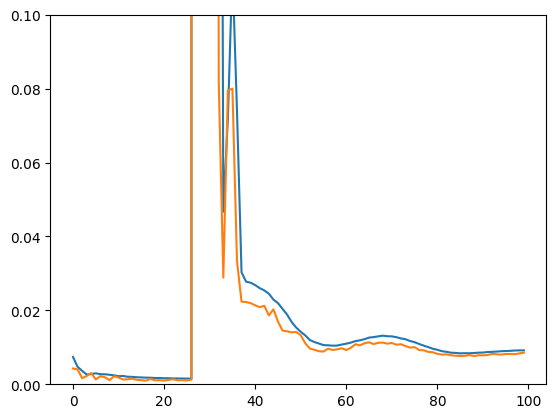

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_train_loss)
plt.plot(total_eval_loss)
plt.ylim(0,0.1)
plt.show()

In [9]:
# Save model
torch.save(model.state_dict(), 'models/parc_v3_final.pth')

Reconstruct CFD output

In [34]:
# Model initializing
model = PARC(
    n_fields=args.n_fields,
    n_timesteps=args.n_timesteps,
    n_hiddenfields=args.n_hiddenfields,
    n_meshfields=args.n_meshfields,
    n_bcfields=args.n_bcfields
)
model = model.to(args.device)
model.load_state_dict(torch.load('models/parc_v3_final.pth'))
model.parameters()

<generator object Module.parameters at 0x7f0812ea7920>

Dataset loaded.
-1.0


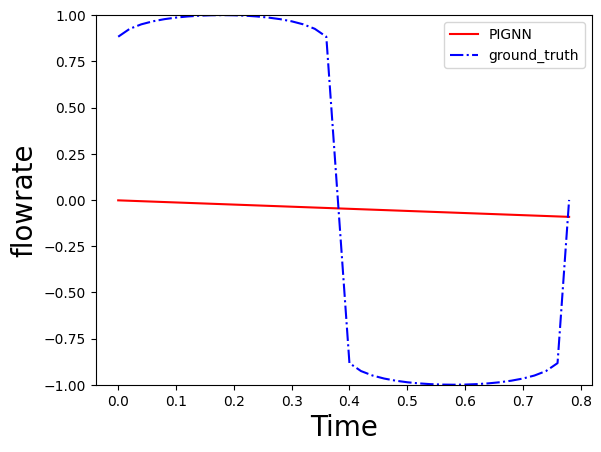

-0.19999999


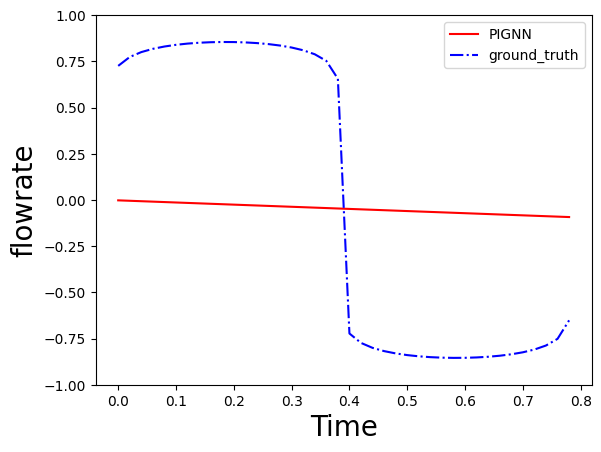

-0.6


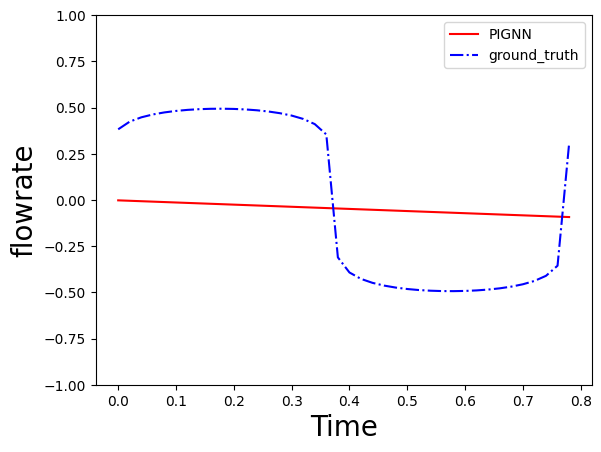

-0.6


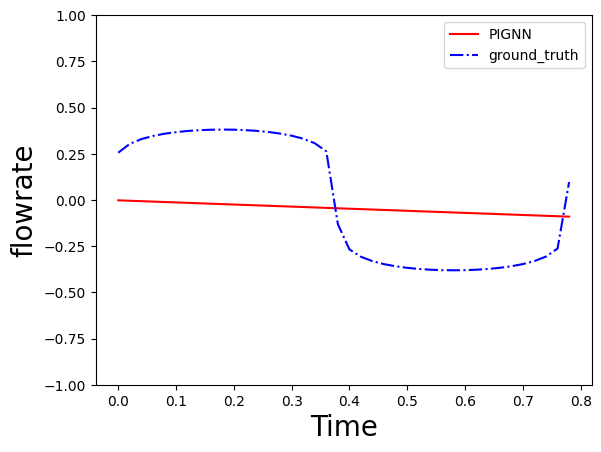

1.0


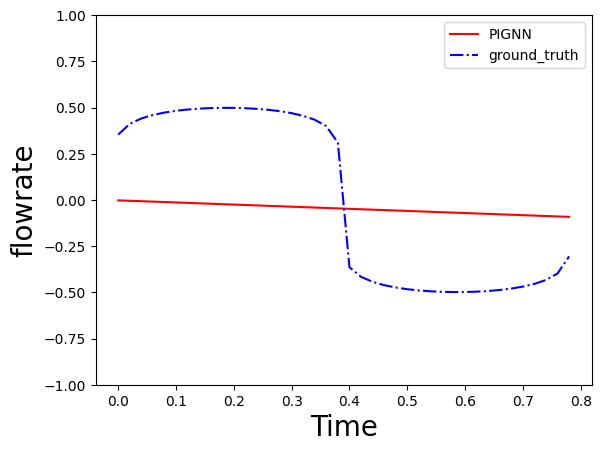

0

In [36]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    n_time = data.pressure.size(1)
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
        )], dim=1).to(args.device)
    mesh_features = data.node_attr.to(args.device)
    F_bc = data.flowrate_bc.to(args.device)
    # weight = data.node_weight.to(args.device)
    F_initial = torch.cat([
        data.pressure[:,0].unsqueeze(1), 
        data.flowrate[:,0].unsqueeze(1)
    ], dim=-1).to(args.device) # concat pressure and flowrate
    model.n_timesteps = n_time - 1

    with torch.no_grad():
        Fs, F_dots = model(F_initial, mesh_features, edge_index, F_bc)

        Fs_hat = torch.cat([data.pressure.unsqueeze(-1), data.flowrate.unsqueeze(-1)], dim=-1)\
                    .to(args.device) # concat pressure and flowrate
        
        # F_dots_hat = cal_derivative(Fs_hat, dim=1, delta_t=args.timesteps)
        F_dots_hat = torch.cat([data.pressure_dot.unsqueeze(-1), data.flowrate_dot.unsqueeze(-1)], dim=-1)\
                .to(args.device)

        Fs_hat = Fs_hat[:,1:,:]
        F_dots_hat = F_dots_hat[:,1:,:]

        # loss = (1.-args.train_lambda)*criterion(Fs_hat, Fs) + \
        #     args.train_lambda*criterion(F_dots_hat, F_dots)
        
        # total_loss = loss.item()
    # print(Fs.size(), Fs_hat.size())
    
    

    
    # plot
    for i_node in [1, 100, 1000, 10000, 50000]:

        i_field = 1
        y_pred = Fs.cpu().numpy()[i_node,:,i_field]
        y_true = Fs_hat.cpu().numpy()[i_node,:,i_field]
        x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
        print(data.node_attr.numpy()[i_node, 6])
        plt.ylim(-1,1)
        plt.plot(x, y_pred, c='red', label='PIGNN')
        plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
        # plt.ylim([-1,1])
        plt.legend(loc='upper right')
        plt.ylabel('flowrate', fontsize=20)
        plt.xlabel('Time', fontsize=20)
        plt.show()
    
    return 0

dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_nodeattr_v2',
    sub_dir='/validation/'
)
print('Dataset loaded.')

plot_comparison(model, dataset[40])